### Import libraries and datasets:

In [97]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [98]:
csv_fts = "D:\\HK2 (NĂM 3)\\RIGHTNOW\\FTS Historical Data.csv"
csv_mwg = "D:\\HK2 (NĂM 3)\\RIGHTNOW\\MWG Historical Data.csv"
csv_vic = "D:\\HK2 (NĂM 3)\\RIGHTNOW\\VIC Historical Data.csv"


df_fts = pd.read_csv(csv_fts, thousands=',')
df_mwg = pd.read_csv(csv_mwg, thousands=',')
df_vic = pd.read_csv(csv_vic, thousands=',')

### Dataset 1: FTS

- Cast Date column to datetime type
- Sort data ascending by Date

In [99]:
df_fts['Date'] = pd.to_datetime(df_fts['Date'])
df_fts = df_fts.sort_values(by='Date', ascending=True)
df_fts.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,5788.4,5859.2,5859.2,5788.4,103.55K,-1.21%
1358,2018-01-03,5953.7,5764.7,5977.4,5741.1,245.02K,2.86%
1357,2018-01-04,6024.6,5953.7,6142.8,5906.5,167.80K,1.19%
1356,2018-01-05,5882.9,5977.4,6048.2,5882.9,113.88K,-2.35%
1355,2018-01-08,6001.0,5859.2,6001.0,5764.7,63.36K,2.01%


- Split Price data
- Reset index

In [100]:
df_price = df_fts[['Price']]
df_price = df_price.reset_index(drop=True)
df_price.head(5)

,Price
0,5788.4
1,5953.7
2,6024.6
3,5882.9
4,6001.0


- Scale data between 0 and 1:

In [101]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_price['Price'] = scaler.fit_transform(np.array(df_price['Price']).reshape(-1,1))
df_price.head(5)

,Price
0,0.000000
1,0.003587
2,0.005125
3,0.002051
4,0.004613


- Split data into train, test, val (7 - 2 - 1):

In [102]:
train_size = int(0.8 * len(df_price))
test_size = int(0.1 * len(df_price))
val_size = len(df_price) - train_size - test_size

train_data = df_price[:train_size]
test_data = df_price[train_size:train_size+test_size]
val_data = df_price[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(1088, 1)
(136, 1)
(136, 1)


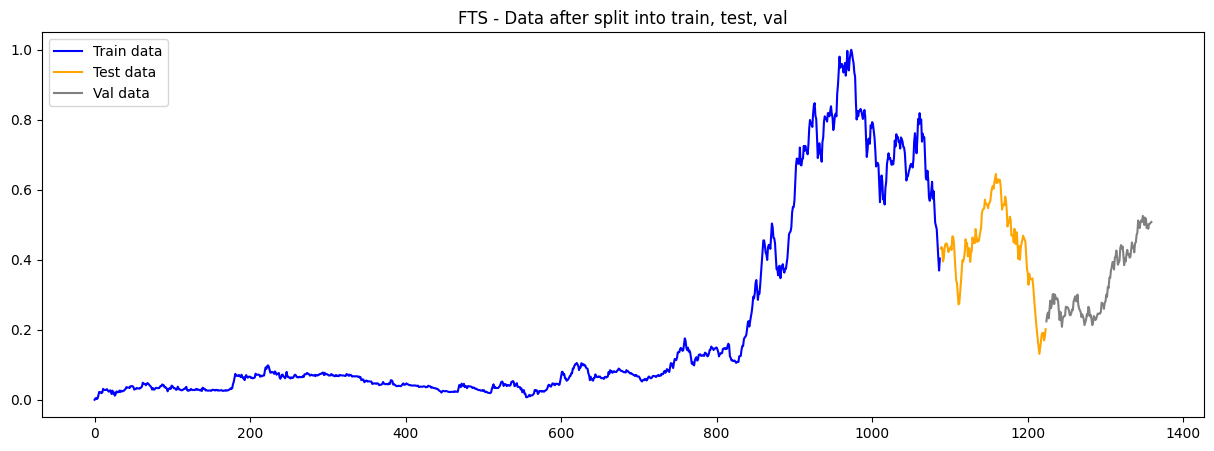

In [103]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Price'], 'b')
plt.plot(test_data.index, test_data['Price'], 'orange')
plt.plot(val_data.index, val_data['Price'], 'gray')
plt.legend(['Train data', 'Test data', 'Val data'], loc='upper left')
plt.title('FTS - Data after split into train, test, val')
plt.show()

- Prepare x, y data:

In [104]:
def make_lags_data(dataset, lags=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - lags - 1):
		a = dataset[i:(i + lags)] 
		dataX.append(a)
		dataY.append(dataset[i + lags])
	return np.array(dataX), np.array(dataY)

In [105]:
lags = 30

x_train, y_train = make_lags_data(train_data['Price'].values, lags=lags)

x_test, y_test = make_lags_data(test_data['Price'].values, lags=lags)

x_val, y_val = make_lags_data(val_data['Price'].values, lags=lags)

- Reshape data:

In [106]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

- Model training:

In [107]:
model_gru = Sequential()
model_gru.add(GRU(64, input_shape=(x_train.shape[1], 1)))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error',optimizer='adam')

In [108]:
model_gru.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100


17/17 [==============================] - 3s 38ms/step - loss: 0.0424 - val_loss: 0.0035
Epoch 2/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0044 - val_loss: 0.0018
Epoch 3/100
17/17 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 4/100
17/17 [==============================] - 0s 15ms/step - loss: 6.7532e-04 - val_loss: 0.0013
Epoch 5/100
17/17 [==============================] - 0s 16ms/step - loss: 5.4000e-04 - val_loss: 0.0012
Epoch 6/100
17/17 [==============================] - 0s 15ms/step - loss: 5.1750e-04 - val_loss: 0.0011
Epoch 7/100
17/17 [==============================] - 0s 14ms/step - loss: 4.8514e-04 - val_loss: 0.0011
Epoch 8/100
17/17 [==============================] - 0s 14ms/step - loss: 4.7018e-04 - val_loss: 0.0011
Epoch 9/100
17/17 [==============================] - 0s 15ms/step - loss: 4.4681e-04 - val_loss: 0.0011
Epoch 10/100
17/17 [==============================] - 0s 15ms/step - loss: 4.4034e-04 - 

- Model Prediction on test, val (one-step prediction):

In [109]:
y_pred_test = model_gru.predict(x_test)
y_pred_val = model_gru.predict(x_val)

y_pred_test = scaler.inverse_transform(y_pred_test)
y_pred_val = scaler.inverse_transform(y_pred_val)

4/4 [==============================] - 0s 4ms/step


- 30 days prediction:

In [110]:
number_of_days_to_predict = 30
n_steps = lags

x_input = df_price[-number_of_days_to_predict-lags:-number_of_days_to_predict]['Price'].values
temp_input = x_input.tolist()

ndays_pred = []

i = 0
while(i < number_of_days_to_predict):
    x_input = np.array(temp_input)
    x_input = x_input.reshape(1, lags, 1)
    y_hat = model_gru.predict(x_input, verbose=0)
    temp_input.extend(y_hat[0])
    temp_input = temp_input[1:]
    ndays_pred.extend(y_hat[0])
    i += 1


In [111]:
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))
ndays_pred

array([[25227.768],
       [25341.656],
       [25463.674],
       [25585.781],
       [25708.385],
       [25830.87 ],
       [25952.96 ],
       [26074.303],
       [26194.744],
       [26314.104],
       [26432.271],
       [26549.092],
       [26664.361],
       [26778.115],
       [26890.264],
       [27000.805],
       [27109.566],
       [27216.418],
       [27321.332],
       [27424.246],
       [27525.281],
       [27624.406],
       [27721.578],
       [27816.838],
       [27910.06 ],
       [28001.117],
       [28090.129],
       [28176.994],
       [28261.832],
       [28344.68 ]], dtype=float32)

- Model evaluating (RMSE - MAPE - MSLE):

In [112]:
last_ndays_data = df_price[-number_of_days_to_predict:]['Price'].values

# RMSE
test_rmse = mean_squared_error(y_pred_test, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(ndays_pred, last_ndays_data, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(ndays_pred, last_ndays_data)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating MAPE:', np.round(val_mape, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred_test, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(ndays_pred, last_ndays_data)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating MSLE:', np.round(val_msle, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))


Testing RMSE: 27217.1266
Validating RMSE: 22524.9674
Predicting 30 days RMSE: 26901.1651

Testing MAPE: 1.0
Validating MAPE: 1.0
Predicting 30 days MAPE: 1.0

Testing MSLE: 95.9436
Validating MSLE: 93.737
Predicting 30 days MSLE: 96.1968


- Prediction plotting:

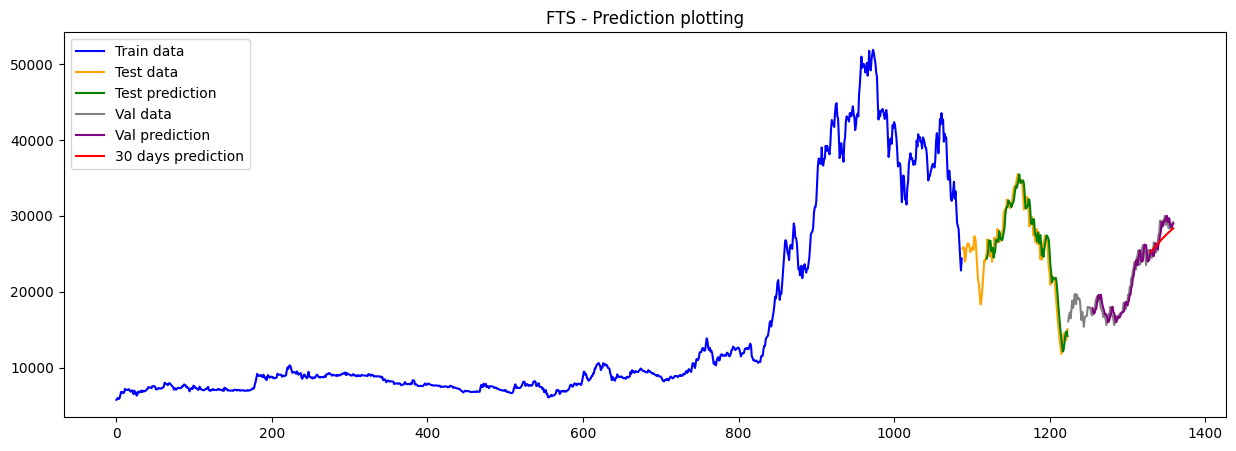

In [113]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), 'orange')

test_data_index = pd.RangeIndex(start=train_size + lags + 1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred_test), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size + lags + 1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df_price)-number_of_days_to_predict, stop=len(df_price), step=1)
plt.plot(prediect_data_index, ndays_pred, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('FTS - Prediction plotting')
plt.show()

### Dataset 2: MWG

In [114]:
df_mwg['Date'] = pd.to_datetime(df_mwg['Date'])
df_mwg = df_mwg.sort_values(by='Date', ascending=True)
df_mwg.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,31276,31039,31394,31039,2.27M,0.76%
1358,2018-01-03,31892,31323,32034,31276,4.53M,1.97%
1357,2018-01-04,31963,31773,32081,31750,2.71M,0.22%
1356,2018-01-05,31608,31987,31987,31465,2.93M,-1.11%
1355,2018-01-08,31110,31394,31513,31039,3.01M,-1.58%


- Split Price data
- Reset index

In [115]:
df_price = df_mwg[['Price']]
df_price = df_price.reset_index(drop=True)
df_price.head(5)

,Price
0,31276
1,31892
2,31963
3,31608
4,31110


- Scale data between 0 and 1:

In [116]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_price['Price'] = scaler.fit_transform(np.array(df_price['Price']).reshape(-1,1))
df_price.head(5)

,Price
0,0.200020
1,0.210221
2,0.211397
3,0.205518
4,0.197271


- Split data into train, test, val (7 - 2 - 1):

In [117]:
train_size = int(0.8 * len(df_price))
test_size = int(0.1 * len(df_price))
val_size = len(df_price) - train_size - test_size

train_data = df_price[:train_size]
test_data = df_price[train_size:train_size+test_size]
val_data = df_price[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(1088, 1)
(136, 1)
(136, 1)


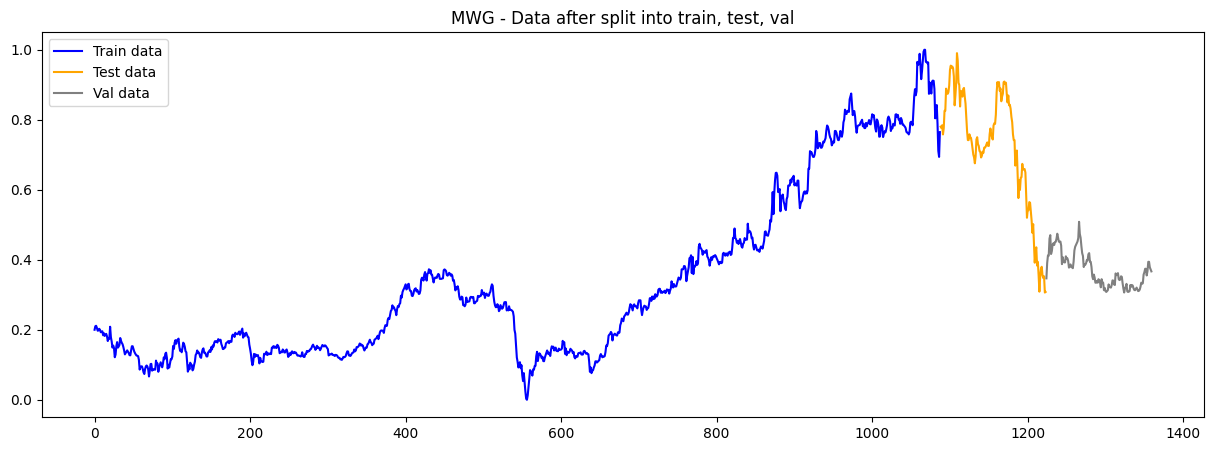

In [118]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Price'], 'b')
plt.plot(test_data.index, test_data['Price'], 'orange')
plt.plot(val_data.index, val_data['Price'], 'gray')
plt.legend(['Train data', 'Test data', 'Val data'], loc='upper left')
plt.title('MWG - Data after split into train, test, val')
plt.show()

- Prepare x, y data:

In [119]:
def make_lags_data(dataset, lags=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - lags - 1):
		a = dataset[i:(i + lags)] 
		dataX.append(a)
		dataY.append(dataset[i + lags])
	return np.array(dataX), np.array(dataY)

In [120]:
lags = 30

x_train, y_train = make_lags_data(train_data['Price'].values, lags=lags)

x_test, y_test = make_lags_data(test_data['Price'].values, lags=lags)

x_val, y_val = make_lags_data(val_data['Price'].values, lags=lags)

- Reshape data:

In [121]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

- Model training:

In [122]:
model_gru = Sequential()
model_gru.add(GRU(64, input_shape=(x_train.shape[1], 1)))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error',optimizer='adam')

In [123]:
model_gru.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
17/17 [==============================] - 3s 41ms/step - loss: 0.0776 - val_loss: 0.0064
Epoch 2/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0154 - val_loss: 0.0184
Epoch 3/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0046 - val_loss: 0.0027
Epoch 4/100
17/17 [==============================] - 0s 15ms/step - loss: 9.6756e-04 - val_loss: 0.0022
Epoch 5/100
17/17 [==============================] - 0s 14ms/step - loss: 6.2935e-04 - val_loss: 0.0024
Epoch 6/100
17/17 [==============================] - 0s 15ms/step - loss: 5.4186e-04 - val_loss: 0.0027
Epoch 7/100
17/17 [==============================] - 0s 15ms/step - loss: 5.2049e-04 - val_loss: 0.0023
Epoch 8/100
17/17 [==============================] - 0s 16ms/step - loss: 4.9572e-04 - val_loss: 0.0022
Epoch 9/100
17/17 [==============================] - 0s 14ms/step - loss: 4.8460e-04 - val_loss: 0.0023
Epoch 10/100
17/17 [==============================] - 0s 16ms/step - loss: 4

- Model Prediction on test, val (one-step prediction):

In [124]:
y_pred_test = model_gru.predict(x_test)
y_pred_val = model_gru.predict(x_val)

y_pred_test = scaler.inverse_transform(y_pred_test)
y_pred_val = scaler.inverse_transform(y_pred_val)

4/4 [==============================] - 0s 5ms/step


- 30 days prediction:

In [125]:
number_of_days_to_predict = 30
n_steps = lags

x_input = df_price[-number_of_days_to_predict-lags:-number_of_days_to_predict]['Price'].values
temp_input = x_input.tolist()

ndays_pred = []

i = 0
while(i < number_of_days_to_predict):
    x_input = np.array(temp_input)
    x_input = x_input.reshape(1, lags, 1)
    y_hat = model_gru.predict(x_input, verbose=0)
    temp_input.extend(y_hat[0])
    temp_input = temp_input[1:]
    ndays_pred.extend(y_hat[0])
    i += 1


In [126]:
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))
ndays_pred

array([[38232.523],
       [38237.85 ],
       [38321.008],
       [38423.066],
       [38531.656],
       [38644.047],
       [38759.242],
       [38876.652],
       [38995.91 ],
       [39116.734],
       [39238.938],
       [39362.383],
       [39486.95 ],
       [39612.59 ],
       [39739.203],
       [39866.773],
       [39995.242],
       [40124.582],
       [40254.777],
       [40385.82 ],
       [40517.688],
       [40650.367],
       [40783.85 ],
       [40918.137],
       [41053.234],
       [41189.137],
       [41325.836],
       [41463.33 ],
       [41601.61 ],
       [41740.695]], dtype=float32)

- Model evaluating (RMSE - MAPE - MSLE):

In [127]:
last_ndays_data = df_price[-number_of_days_to_predict:]['Price'].values

# RMSE
test_rmse = mean_squared_error(y_pred_test, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(ndays_pred, last_ndays_data, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(ndays_pred, last_ndays_data)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating MAPE:', np.round(val_mape, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred_test, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(ndays_pred, last_ndays_data)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating MSLE:', np.round(val_msle, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))


Testing RMSE: 61892.99
Validating RMSE: 41044.9211
Predicting 30 days RMSE: 39862.7534

Testing MAPE: 1.0
Validating MAPE: 1.0
Predicting 30 days MAPE: 1.0

Testing MSLE: 110.0688
Validating MSLE: 106.3727
Predicting 30 days MSLE: 106.1006


- Prediction plotting:

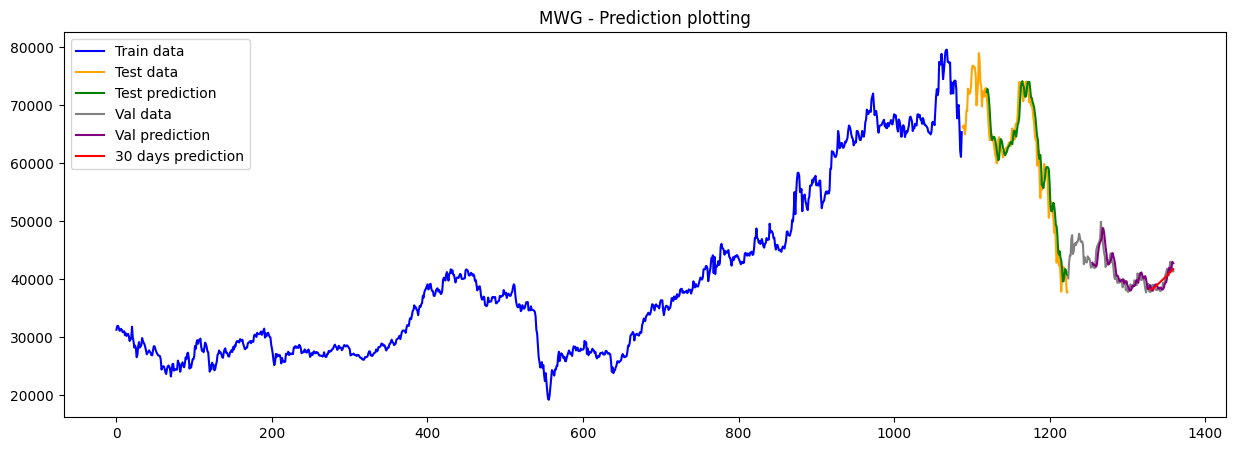

In [128]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), 'orange')

test_data_index = pd.RangeIndex(start=train_size + lags + 1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred_test), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size + lags + 1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df_price)-number_of_days_to_predict, stop=len(df_price), step=1)
plt.plot(prediect_data_index, ndays_pred, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('MWG - Prediction plotting')
plt.show()

- Prediction plotting:

### Dataset 3: VIC

In [129]:
df_vic['Date'] = pd.to_datetime(df_vic['Date'])
df_vic = df_vic.sort_values(by='Date', ascending=True)
df_vic.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,64628,64132,64876,63967,1.74M,1.16%
1358,2018-01-03,66529,65702,68760,64959,6.07M,2.94%
1357,2018-01-04,66942,67355,68678,66529,3.55M,0.62%
1356,2018-01-05,66116,66942,66942,65289,3.42M,-1.23%
1355,2018-01-08,66364,66116,67686,65372,4.81M,0.38%


- Split Price data
- Reset index

In [130]:
df_price = df_vic[['Price']]
df_price = df_price.reset_index(drop=True)
df_price.head(5)

,Price
0,64628
1,66529
2,66942
3,66116
4,66364


- Scale data between 0 and 1:

In [131]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_price['Price'] = scaler.fit_transform(np.array(df_price['Price']).reshape(-1,1))
df_price.head(5)

,Price
0,0.182297
1,0.206826
2,0.212155
3,0.201497
4,0.204697


- Split data into train, test, val (7 - 2 - 1):

In [132]:
train_size = int(0.8 * len(df_price))
test_size = int(0.1 * len(df_price))
val_size = len(df_price) - train_size - test_size

train_data = df_price[:train_size]
test_data = df_price[train_size:train_size+test_size]
val_data = df_price[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(1088, 1)
(136, 1)
(136, 1)


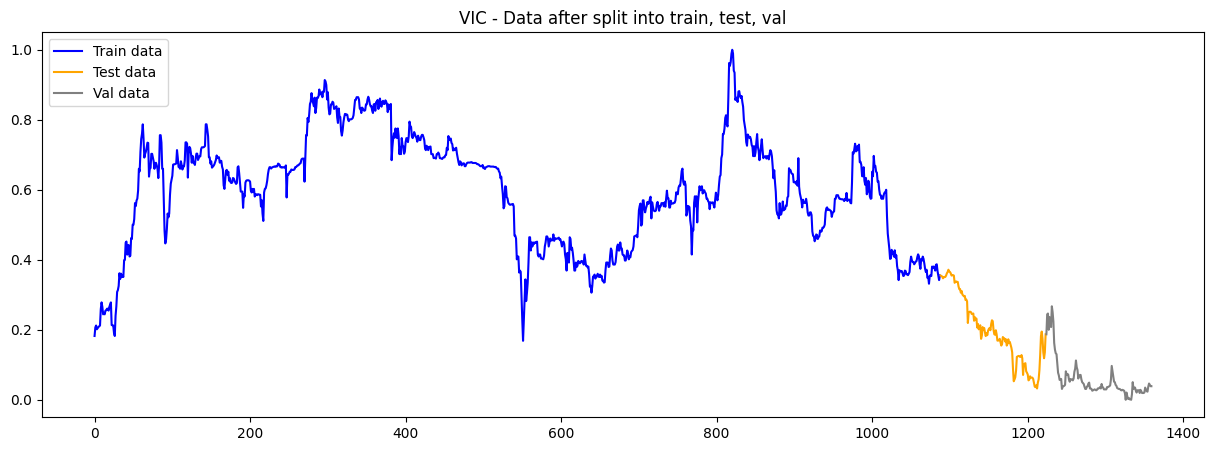

In [133]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Price'], 'b')
plt.plot(test_data.index, test_data['Price'], 'orange')
plt.plot(val_data.index, val_data['Price'], 'gray')
plt.legend(['Train data', 'Test data', 'Val data'], loc='upper left')
plt.title('VIC - Data after split into train, test, val')
plt.show()

- Prepare x, y data:

In [134]:
def make_lags_data(dataset, lags=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - lags - 1):
		a = dataset[i:(i + lags)] 
		dataX.append(a)
		dataY.append(dataset[i + lags])
	return np.array(dataX), np.array(dataY)

In [135]:
lags = 30

x_train, y_train = make_lags_data(train_data['Price'].values, lags=lags)

x_test, y_test = make_lags_data(test_data['Price'].values, lags=lags)

x_val, y_val = make_lags_data(val_data['Price'].values, lags=lags)

- Reshape data:

In [136]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

- Model training:

In [137]:
model_gru = Sequential()
model_gru.add(GRU(64, input_shape=(x_train.shape[1], 1)))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error',optimizer='adam')

In [138]:
model_gru.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
17/17 [==============================] - 3s 43ms/step - loss: 0.2027 - val_loss: 0.0387
Epoch 2/100
17/17 [==============================] - 0s 18ms/step - loss: 0.0146 - val_loss: 0.0393
Epoch 3/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0060 - val_loss: 0.0293
Epoch 4/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0043 - val_loss: 0.0342
Epoch 5/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0039 - val_loss: 0.0274
Epoch 6/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0034 - val_loss: 0.0246
Epoch 7/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0031 - val_loss: 0.0211
Epoch 8/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0027 - val_loss: 0.0182
Epoch 9/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0024 - val_loss: 0.0151
Epoch 10/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0021 - val_loss: 0.0119

- Model Prediction on test, val (one-step prediction):

In [139]:
y_pred_test = model_gru.predict(x_test)
y_pred_val = model_gru.predict(x_val)

y_pred_test = scaler.inverse_transform(y_pred_test)
y_pred_val = scaler.inverse_transform(y_pred_val)

4/4 [==============================] - 0s 5ms/step


- 30 days prediction:

In [140]:
number_of_days_to_predict = 30
n_steps = lags

x_input = df_price[-number_of_days_to_predict-lags:-number_of_days_to_predict]['Price'].values
temp_input = x_input.tolist()

ndays_pred = []

i = 0
while(i < number_of_days_to_predict):
    x_input = np.array(temp_input)
    x_input = x_input.reshape(1, lags, 1)
    y_hat = model_gru.predict(x_input, verbose=0)
    temp_input.extend(y_hat[0])
    temp_input = temp_input[1:]
    ndays_pred.extend(y_hat[0])
    i += 1


In [141]:
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))
ndays_pred

array([[52841.664],
       [53522.38 ],
       [54339.348],
       [55187.36 ],
       [56041.668],
       [56893.12 ],
       [57737.297],
       [58571.816],
       [59395.387],
       [60207.277],
       [61007.1  ],
       [61794.676],
       [62569.914],
       [63332.84 ],
       [64083.516],
       [64822.043],
       [65548.54 ],
       [66263.16 ],
       [66966.05 ],
       [67657.375],
       [68337.32 ],
       [69006.055],
       [69663.74 ],
       [70310.57 ],
       [70946.71 ],
       [71572.336],
       [72187.62 ],
       [72792.7  ],
       [73387.79 ],
       [73973.01 ]], dtype=float32)

- Model evaluating (RMSE - MAPE - MSLE):

In [142]:
last_ndays_data = df_price[-number_of_days_to_predict:]['Price'].values

# RMSE
test_rmse = mean_squared_error(y_pred_test, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(ndays_pred, last_ndays_data, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(ndays_pred, last_ndays_data)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating MAPE:', np.round(val_mape, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred_test, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(ndays_pred, last_ndays_data)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating MSLE:', np.round(val_msle, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))


Testing RMSE: 64363.4823
Validating RMSE: 55115.7899
Predicting 30 days RMSE: 64349.6237

Testing MAPE: 1.0
Validating MAPE: 1.0
Predicting 30 days MAPE: 1.0

Testing MSLE: 119.2607
Validating MSLE: 118.3624
Predicting 30 days MSLE: 121.821


- Prediction plotting:

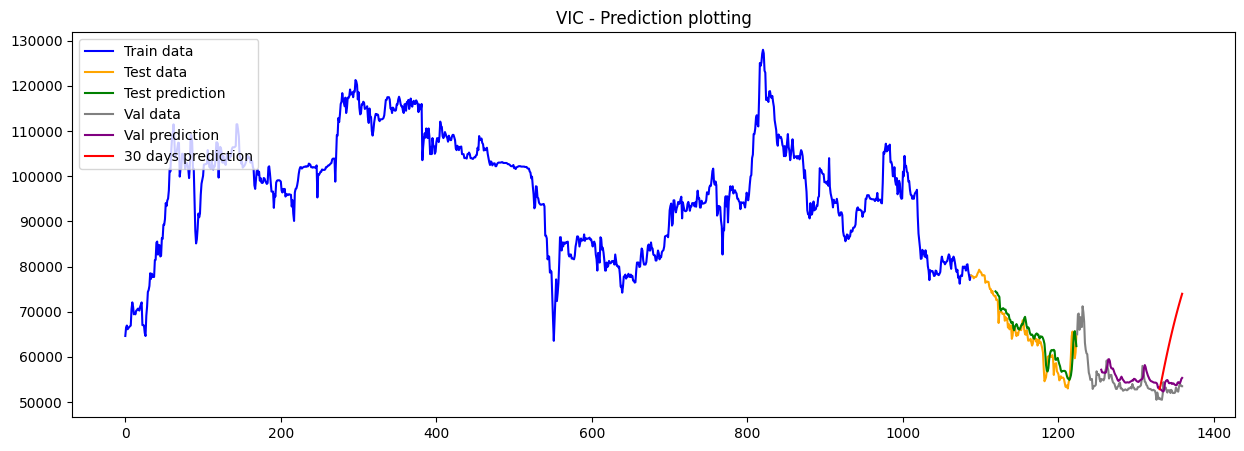

In [143]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), 'orange')

test_data_index = pd.RangeIndex(start=train_size + lags + 1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred_test), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size + lags + 1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df_price)-number_of_days_to_predict, stop=len(df_price), step=1)
plt.plot(prediect_data_index, ndays_pred, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('VIC - Prediction plotting')
plt.show()